## Imports

In [1]:
# The OS module in Python provides functions for interacting with the operating system
import os

# import the necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tsa statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# auto arima
#!pip install pmdarima
import pmdarima as pm

# scipy
from scipy import stats
from scipy.special import inv_boxcox

# sklearn
from sklearn.metrics import mean_squared_error


## Load Data
Data: Monthly median AQI levels of the US from 1980-2022

In [2]:
path = 'C:/Users/KNguyen/Desktop/springboard/Capstone3_AQI/data/processed/median_AQI_monthly.csv'
df = pd.read_csv(path, parse_dates=['Date'])
df.head()

,Date,AQI
0,1980-01-31,34.0
1,1980-02-29,38.0
2,1980-03-31,39.0
3,1980-04-30,44.0
4,1980-05-31,50.0


In [3]:
df.set_index('Date', inplace=True)

Text(0.5, 0.98, 'Untransformed Data and its Histogram')

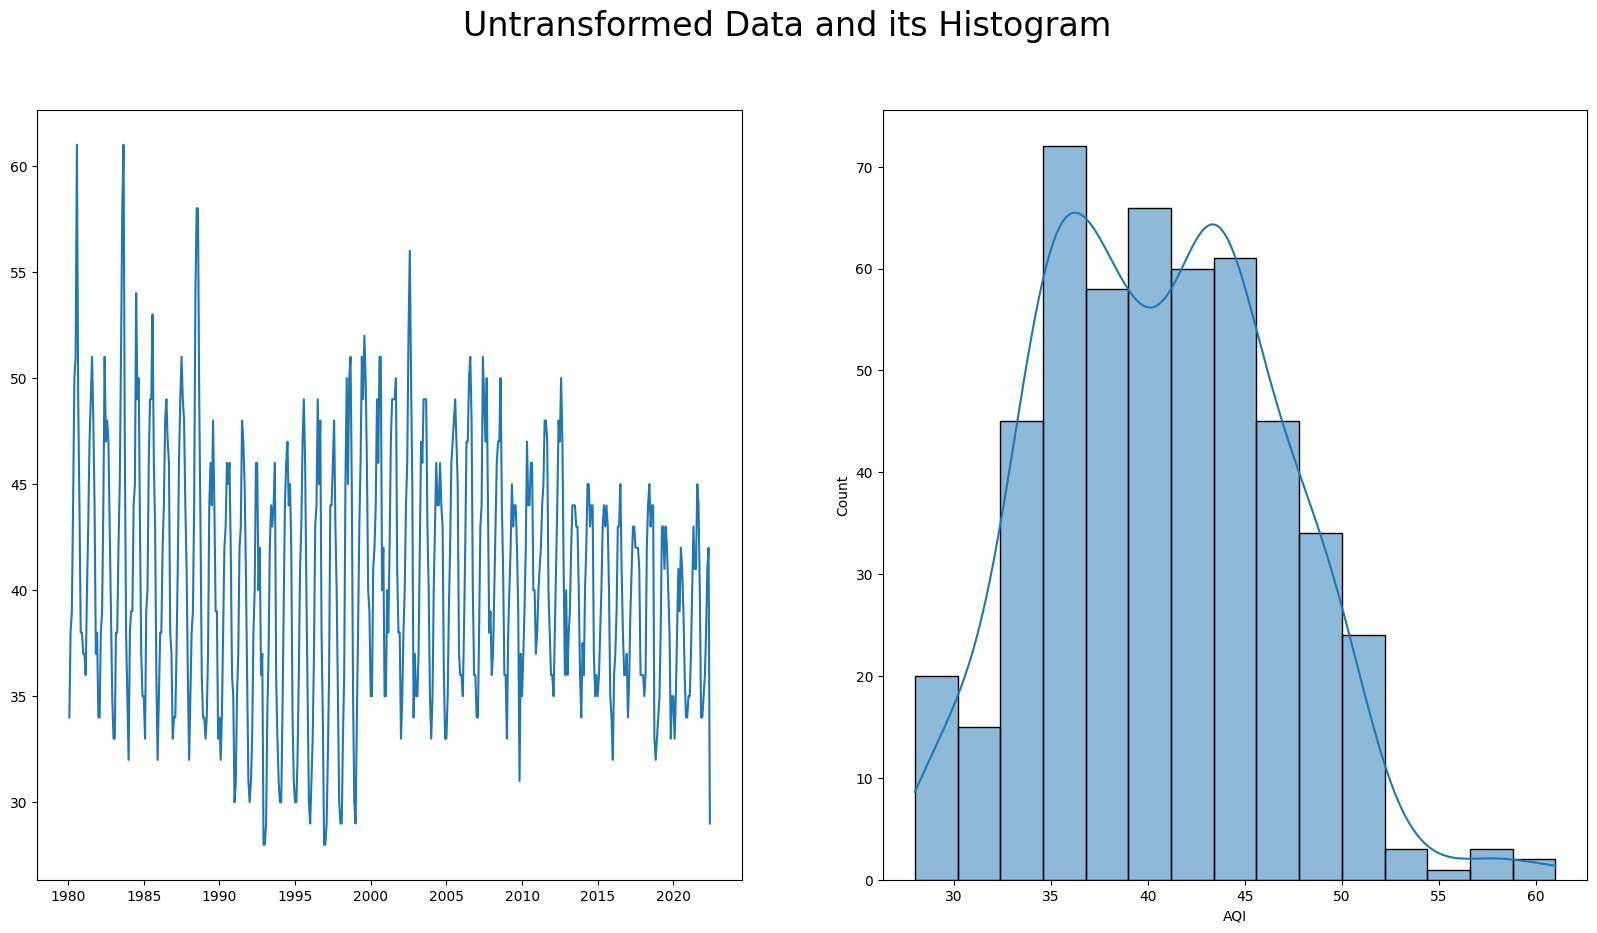

In [4]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(df.AQI)
#ax[0].axhline(y=df.AQI.mean(), c='red')
sns.histplot(data=df, x='AQI', bins=15, ax=ax[1], kde=True)
plt.suptitle('Untransformed Data and its Histogram', fontsize=24)

## Transforming the Data

In [5]:
# sqrt transform
df_sqrt = pd.DataFrame({'ds': df.index, 'y_sqrt': np.sqrt(df.AQI)}).set_index('ds')
df_sqrt.head()

,y_sqrt
ds,
1980-01-31,5.830952
1980-02-29,6.164414
1980-03-31,6.244998
1980-04-30,6.633250
1980-05-31,7.071068


Text(0.5, 0.98, 'Sqrt-Transformed Data and its Histogram')

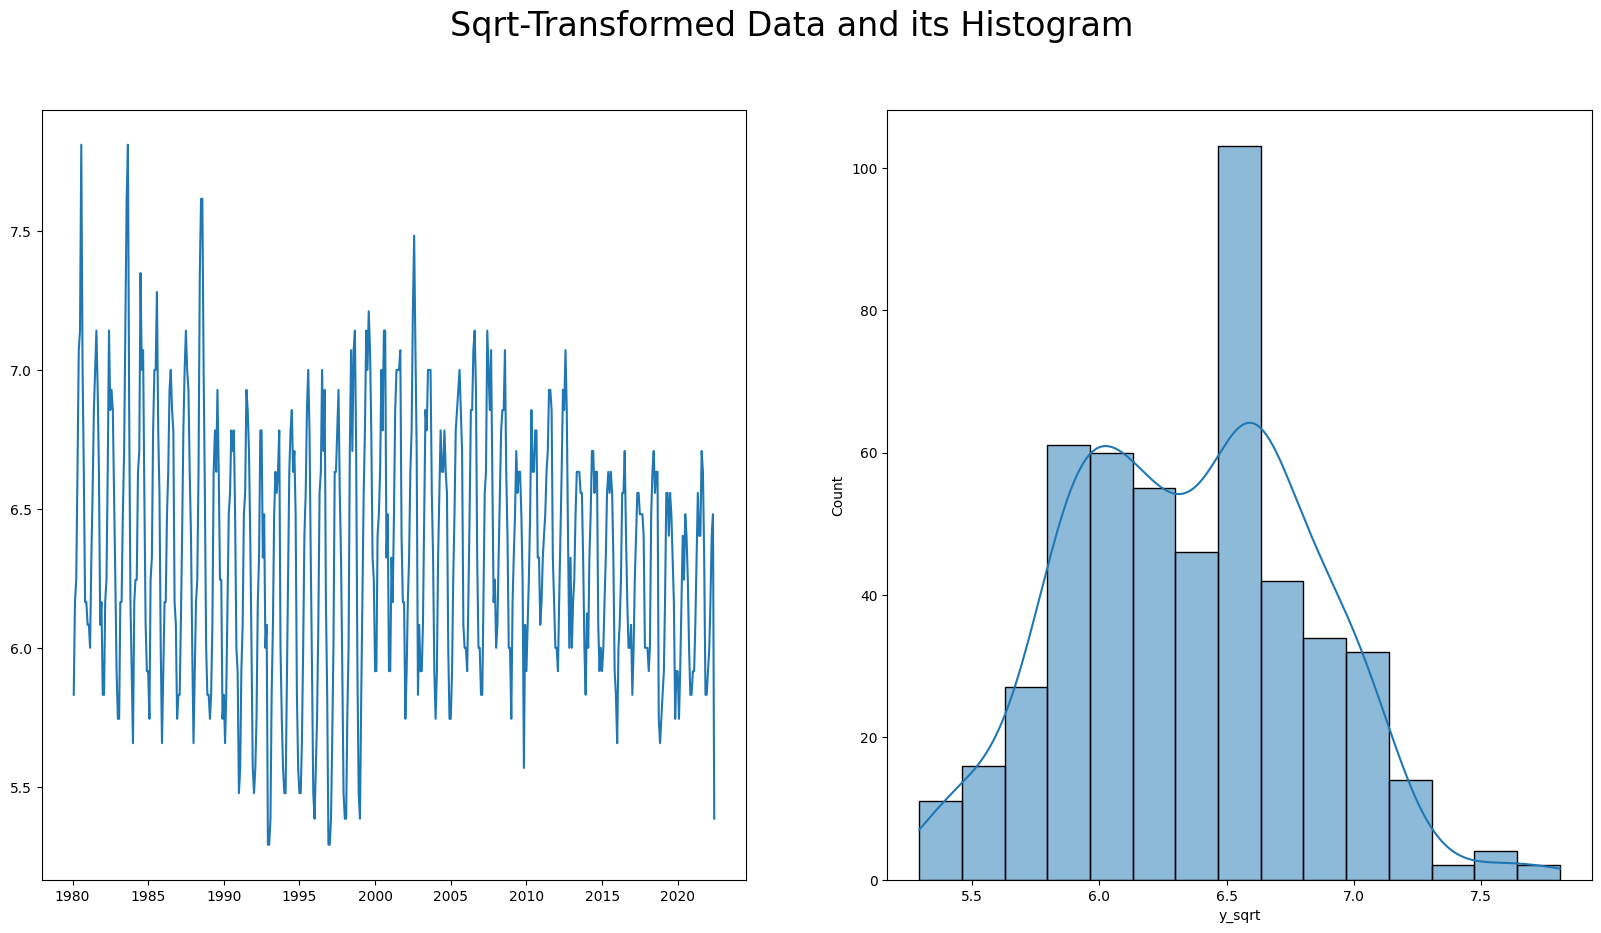

In [6]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(df_sqrt.y_sqrt)
sns.histplot(data=df_sqrt, x='y_sqrt', bins=15, ax=ax[1], kde=True)
plt.suptitle('Sqrt-Transformed Data and its Histogram', fontsize=24)

In [7]:
# box-cox transform

boxcox_data, best_lambda, ci = stats.boxcox(df.AQI, alpha=0.95) #alpha = confidence interval

df_bc = pd.DataFrame(boxcox_data,index = df.index, columns=['AQI'])
df_bc.head()

,AQI
Date,
1980-01-31,5.513483
1980-02-29,5.773496
1980-03-31,5.835213
1980-04-30,6.126856
1980-05-31,6.445157


Text(0.5, 0.98, 'Optimal BoxCox-transformed Data and its Histogram')

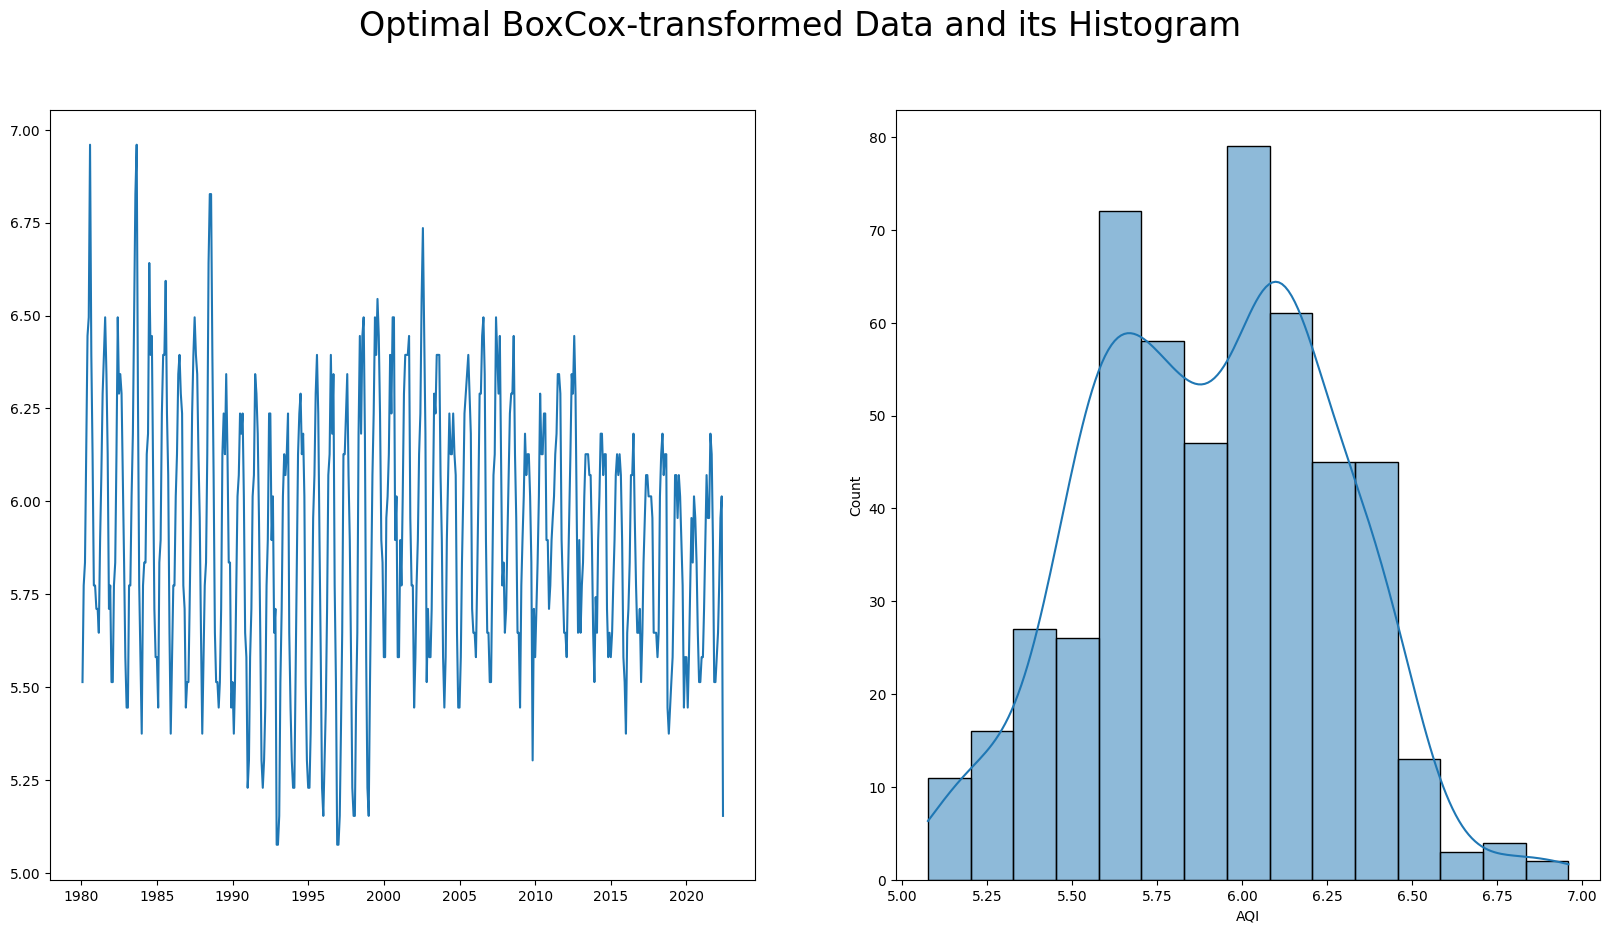

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(df_bc.AQI)
sns.histplot(data=df_bc, x='AQI', bins=15, ax=ax[1], kde=True)
plt.suptitle('Optimal BoxCox-transformed Data and its Histogram', fontsize=24)

In [9]:
print('Optimal lambda value: ', best_lambda)
print('Confidence Interval: ', ci)

Optimal lambda value:  0.23706028832402673
Confidence Interval:  (0.2202146964325103, 0.2539038612877807)


Use Box-Cox data to figure out P,D,Q, p,d,q, s values for SARIMA model:

## ACF/ PACF for df_bc and Selecting Values for SARIMA

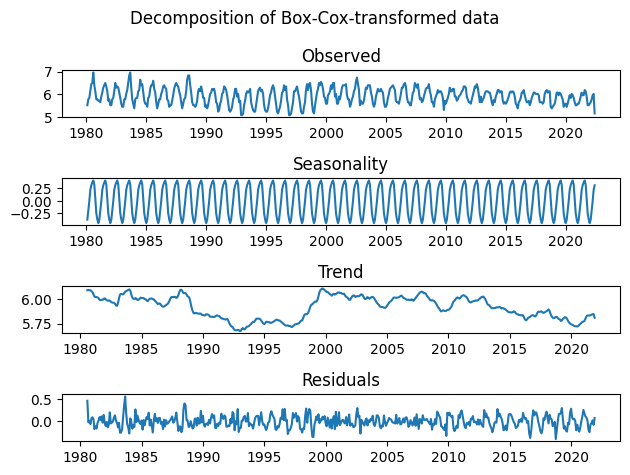

In [10]:
bc_decomp = seasonal_decompose(df_bc)
fig, ax = plt.subplots(4)
fig.suptitle('Decomposition of Box-Cox-transformed data')

ax[0].plot(bc_decomp.observed)
ax[0].set_title('Observed')

ax[1].plot(bc_decomp.seasonal)
ax[1].set_title('Seasonality')

ax[2].plot(bc_decomp.trend)
ax[2].set_title('Trend')

ax[3].plot(bc_decomp.resid)
ax[3].set_title('Residuals')

fig.tight_layout()
plt.show()

C:\Users\KNguyen\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


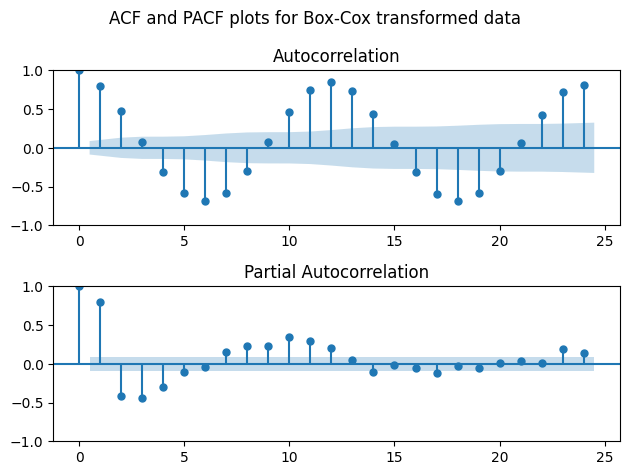

Variance:  0.126435602644882


In [11]:

%matplotlib inline

fig, ax = plt.subplots(2,1)

plot_acf(df_bc.AQI, lags=24, ax=ax[0])

plot_pacf(df_bc.AQI, lags=24, ax=ax[1])

plt.suptitle('ACF and PACF plots for Box-Cox transformed data')

fig.tight_layout()
plt.show()


print('Variance: ', df_bc.AQI.var())

ACF plot suggests lag 12 seasonality; take the difference at lag 12 below.

#### Differencing with df_bc

Variance:  0.031171921741034156


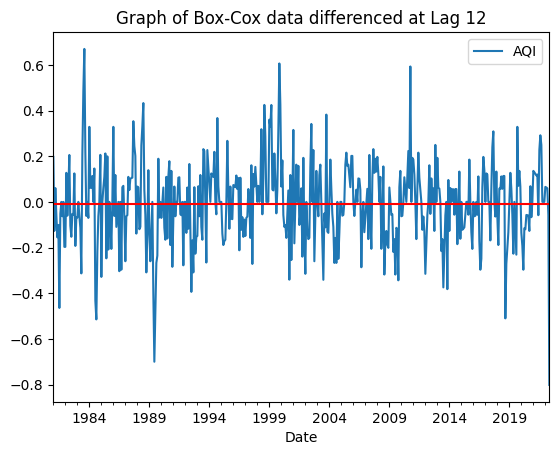

In [12]:
# seasonal difference

df_bc_diff12 = df_bc.diff(12)

df_bc_diff12.dropna().plot()

plt.axhline(y=df_bc_diff12.AQI.mean(), color ='r')

plt.title('Graph of Box-Cox data differenced at Lag 12')

print('Variance: ', df_bc_diff12.AQI.var()) # smaller than df_bc's, good

Looks like there might still be a trend; try differencing at lag 1, and compare variance.

Variance:  0.041955477324719666


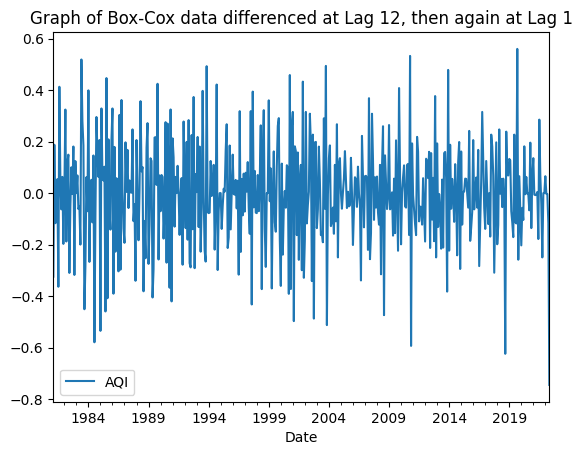

In [13]:
# trend difference

df_bc_diff12_diff = df_bc_diff12.diff()

df_bc_diff12_diff.dropna().plot()

plt.title('Graph of Box-Cox data differenced at Lag 12, then again at Lag 1')


print('Variance: ', df_bc_diff12_diff.AQI.var()) # larger than df_bc_diff12's, bad
# keep df_log_diff12 without the trend difference

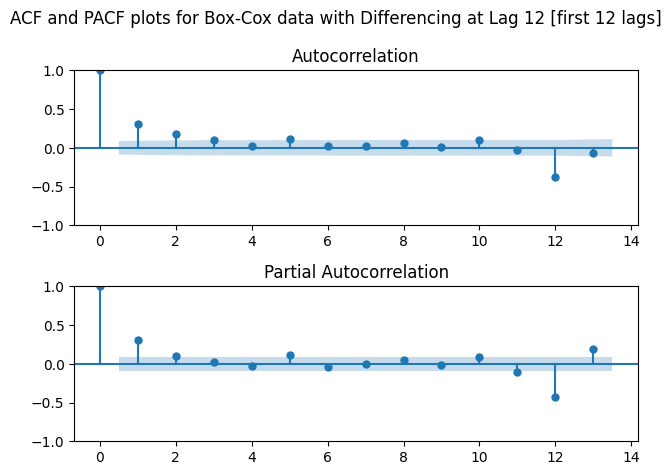

In [14]:
%matplotlib inline

fig, ax = plt.subplots(2,1)

plot_acf(df_bc_diff12.AQI.dropna(), lags=13, ax=ax[0])

plot_pacf(df_bc_diff12.AQI.dropna(), lags=13, ax=ax[1])

plt.suptitle('ACF and PACF plots for Box-Cox data with Differencing at Lag 12 [first 12 lags]')

fig.tight_layout()
plt.show()


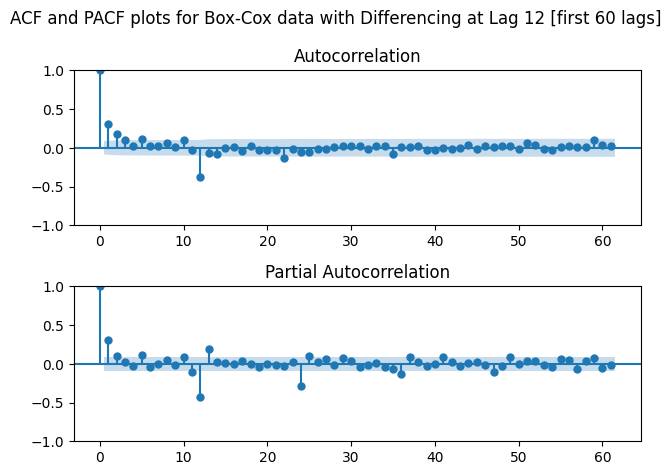

In [15]:
%matplotlib inline

fig, ax = plt.subplots(2,1)

plot_acf(df_bc_diff12.AQI.dropna(), lags=61, ax=ax[0])

plot_pacf(df_bc_diff12.AQI.dropna(), lags=61, ax=ax[1])

plt.suptitle('ACF and PACF plots for Box-Cox data with Differencing at Lag 12 [first 60 lags]')

fig.tight_layout()
plt.show()


Values for SARIMA from ACF/PACF:
<br>
s=12
<br>
d=0
<br>
D=1
<br>
p = 0,1,2
<br>
q = 1,2
<br>
P = 2
<br>
Q = 1

In [16]:
# save all the transformed data, just in case we need them

df.to_csv('C:/Users/KNguyen/Desktop/springboard/Capstone3_AQI/data/processed/median_AQI_untransformed.csv')
df_sqrt.to_csv('C:/Users/KNguyen/Desktop/springboard/Capstone3_AQI/data/processed/median_AQI_sqrt.csv')
df_bc.to_csv('C:/Users/KNguyen/Desktop/springboard/Capstone3_AQI/data/processed/median_AQI_bc.csv')



In [17]:
# train-test split

train = df_bc.iloc[:len(df_bc)-12]
test = df_bc.iloc[len(df_bc)-12:]

#train.tail()
#test.head()

## Model 1: SARIMA (2,0,1) x (0,1,1)_12 on df_bc (chosen by auto_arima)

In [18]:
#https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
#https://sailajakarra.medium.com/time-series-predictions-using-arima-sarimax-e6724844cae0

# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(train, start_p=0, start_q=1,
                         test='adf',
                         max_p=2, max_q=2, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
# auto_arima chooses the model with the lowest AIC score

In [19]:
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  497
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 301.595
Date:                            Fri, 03 Feb 2023   AIC                           -593.191
Time:                                    14:09:11   BIC                           -572.270
Sample:                                01-31-1980   HQIC                          -584.971
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3109      0.065     20.252      0.000       1.184       1.438
ar.L2         -0.3250      0.057     -5.674      0.000      -0.437      -0.213
ma.L1         -0.8954      0.039    -22.779      0.000      -0.972      -0.818
ma.S.L12      -0.8069      0.032    -25.318      0.000      -0.869      -0.744
sigma2         0.0165      0.001     17.741      0.000       0.015       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                12.04
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

p-value for Ljung-Box test is greater than 0.05, so we fail to reject the null hypothesis. So, the residuals are independently distributed, which is good.

In [20]:
# fit model on train set
sarima1 = SARIMAX(train, order=(2, 0, 1), seasonal_order=(0, 1, 1, 12))
results1 = sarima1.fit()

C:\Users\KNguyen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\KNguyen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


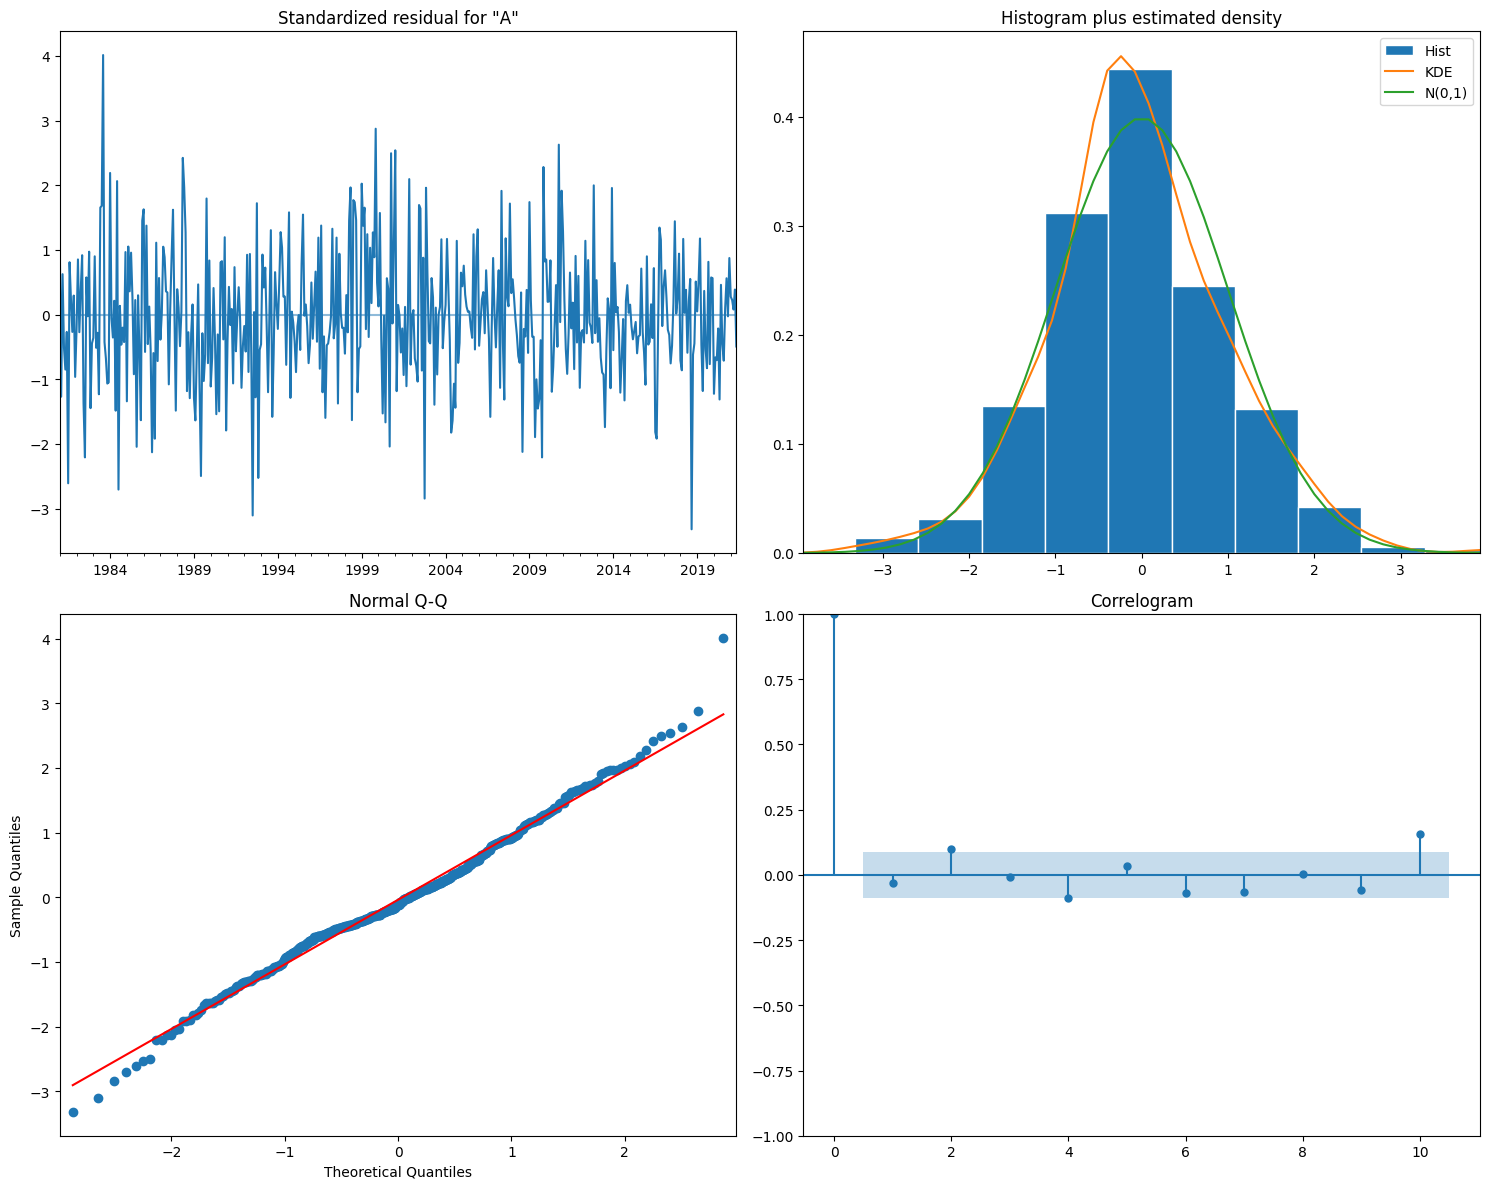

In [21]:
results1.plot_diagnostics(figsize=(15,12))
plt.tight_layout()

Graph of residuals resemble white noise, and histogram and Normal Q-Q plots suggest the residuals resemble a normal distribution. However the ACF plot suggests that the residuals may not resemble white noise, since there is a nonzero ACF at lag 10. Modify the model by trying q=10.

In [22]:
#?SARIMAX

## Model 2: SARIMA (2,0,10) x (0,1,1)_12 on df_bc


C:\Users\KNguyen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\KNguyen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\KNguyen\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


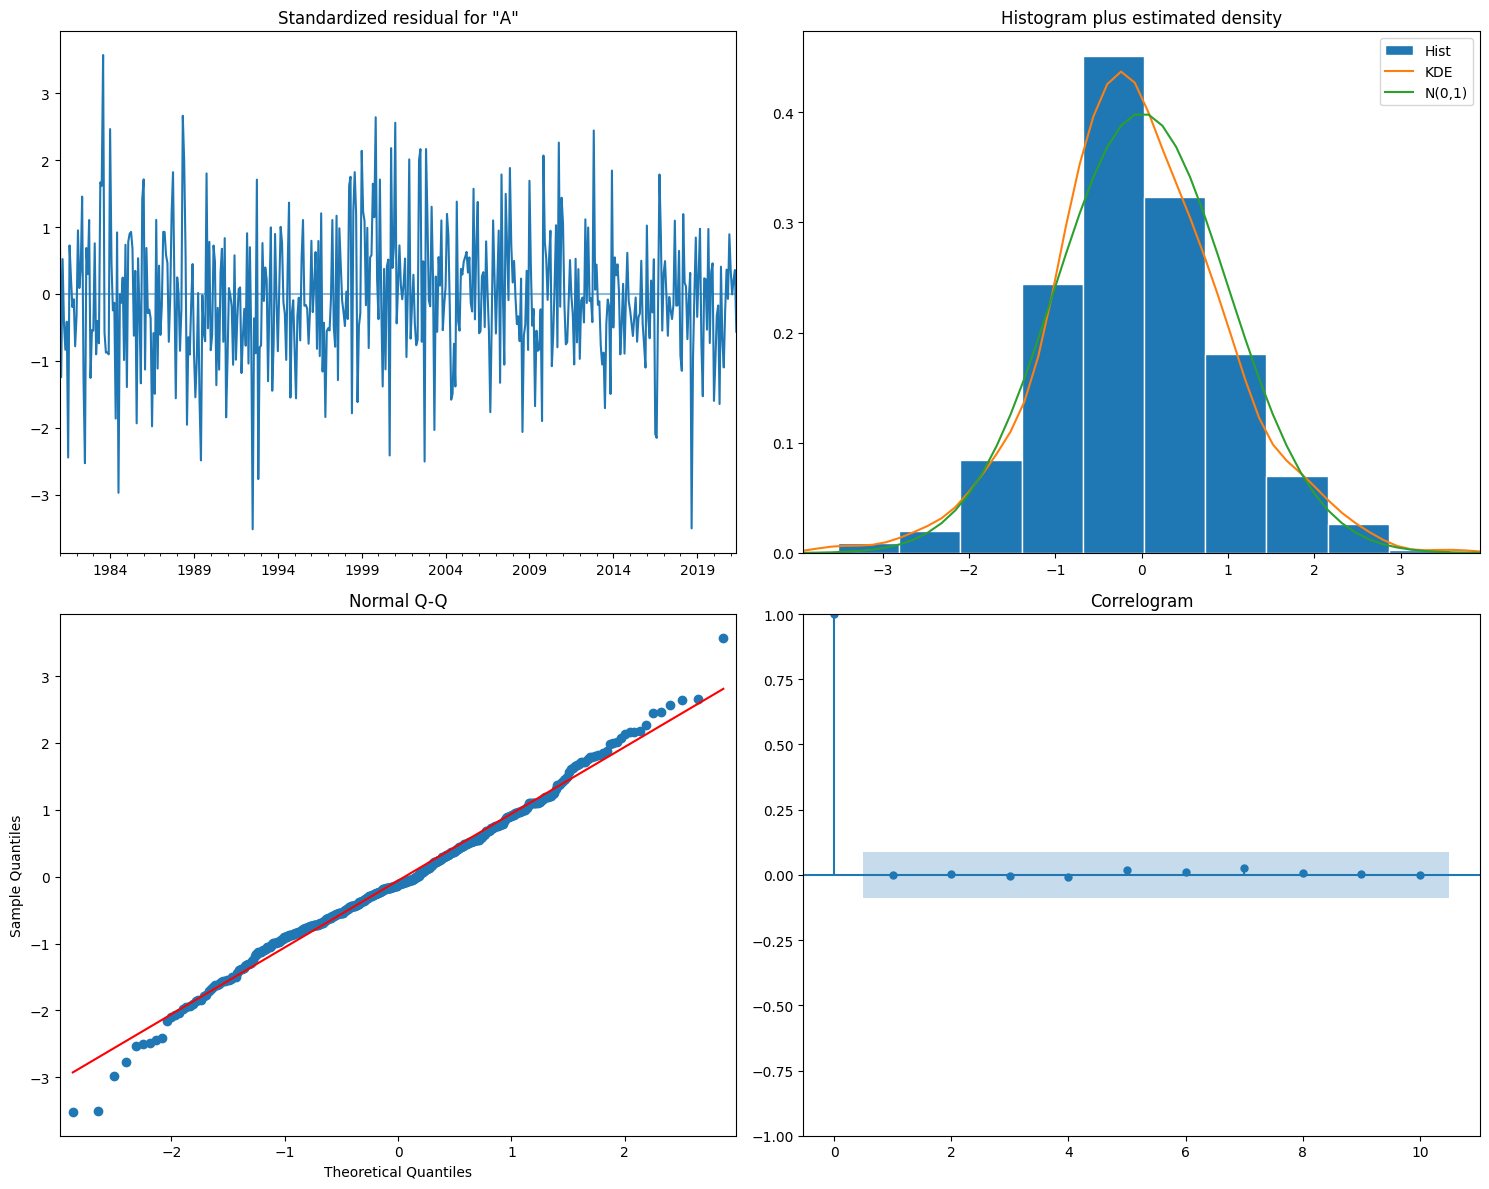

In [23]:
sarima2 = SARIMAX(train, order=(2, 0, 10), seasonal_order=(0, 1, 1, 12))
results2 = sarima2.fit()

results2.plot_diagnostics(figsize=(15,12))
plt.tight_layout()


In [24]:
results2.summary() #lower AIC than results1, but fails Ljung-Box! Plus it's complex

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                   AQI   No. Observations:                  497
Model:             SARIMAX(2, 0, 10)x(0, 1, [1], 12)   Log Likelihood                 314.080
Date:                               Fri, 03 Feb 2023   AIC                           -600.159
Time:                                       14:09:26   BIC                           -541.581
Sample:                                   01-31-1980   HQIC                          -577.143
                                        - 05-31-2021                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9773      0.212      4.603      0.000       0.561       1.393
ar.L2         -0.1425      0.200     -0.712      0.476      -0.535       0.250
ma.L1         -0.5865      0.206     -2.840      0.005      -0.991      -0.182
ma.L2          0.0887      0.132      0.672      0.502      -0.170       0.348
ma.L3         -0.0834      0.059     -1.413      0.158      -0.199       0.032
ma.L4         -0.0430      0.056     -0.766      0.444      -0.153       0.067
ma.L5          0.0639      0.053      1.216      0.224      -0.039       0.167
ma.L6         -0.0475      0.059     -0.810      0.418      -0.163       0.067
ma.L7         -0.0218      0.054     -0.403      0.687      -0.128       0.084
ma.L8          0.0374      0.055      0.677      0.498      -0.071       0.146
ma.L9         -0.0062      0.059     -0.105      0.916      -0.121       0.109
ma.L10         0.2249      0.055      4.065      0.000       0.116       0.333
ma.S.L12      -0.8234      0.031    -26.196      0.000      -0.885      -0.762
sigma2         0.0155      0.001     17.117      0.000       0.014       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This model fails the Ljung-Box test! Zero out some of the coefficients by looking at the CI.

In [25]:
results2.params # returns coefficients

ar.L1       0.977260
ar.L2      -0.142531
ma.L1      -0.586454
ma.L2       0.088726
ma.L3      -0.083357
ma.L4      -0.043020
ma.L5       0.063946
ma.L6      -0.047521
ma.L7      -0.021770
ma.L8       0.037428
ma.L9      -0.006179
ma.L10      0.224884
ma.S.L12   -0.823398
sigma2      0.015549
dtype: float64

In [26]:
# use CI to zero out some coeffs
coeffs2 = results2.params

coeffs2.iloc[[1,3,6,7,8,9,10]] = 0

coeffs2 #new coeffs in the indices above should be replaced by 0.

ar.L1       0.977260
ar.L2       0.000000
ma.L1      -0.586454
ma.L2       0.000000
ma.L3      -0.083357
ma.L4      -0.043020
ma.L5       0.000000
ma.L6       0.000000
ma.L7       0.000000
ma.L8       0.000000
ma.L9       0.000000
ma.L10      0.224884
ma.S.L12   -0.823398
sigma2      0.015549
dtype: float64

In [27]:
#https://github.com/statsmodels/statsmodels/issues/5226

res2 = sarima2.smooth(coeffs2) #smooth() fits the new coeff's to sarima2

In [28]:
res2.summary() #passes Ljung-Box test!

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                   AQI   No. Observations:                  497
Model:             SARIMAX(2, 0, 10)x(0, 1, [1], 12)   Log Likelihood                 302.767
Date:                               Fri, 03 Feb 2023   AIC                           -577.534
Time:                                       14:09:27   BIC                           -518.956
Sample:                                   01-31-1980   HQIC                          -554.519
                                        - 05-31-2021                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9773      0.208      4.705      0.000       0.570       1.384
ar.L2               0      0.210          0      1.000      -0.411       0.411
ma.L1         -0.5865      0.201     -2.920      0.003      -0.980      -0.193
ma.L2               0      0.139          0      1.000      -0.273       0.273
ma.L3         -0.0834      0.054     -1.537      0.124      -0.190       0.023
ma.L4         -0.0430      0.053     -0.807      0.420      -0.148       0.062
ma.L5               0      0.049          0      1.000      -0.096       0.096
ma.L6               0      0.056          0      1.000      -0.109       0.109
ma.L7               0      0.051          0      1.000      -0.100       0.100
ma.L8               0      0.056          0      1.000      -0.109       0.109
ma.L9               0      0.058          0      1.000      -0.114       0.114
ma.L10         0.2249      0.053      4.243      0.000       0.121       0.329
ma.S.L12      -0.8234      0.030    -27.297      0.000      -0.883      -0.764
sigma2         0.0155      0.001     17.107      0.000       0.014       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 6.14
Prob(Q):                              0.40   Prob(JB):                         0.05
Heteroskedasticity (H):               0.62   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

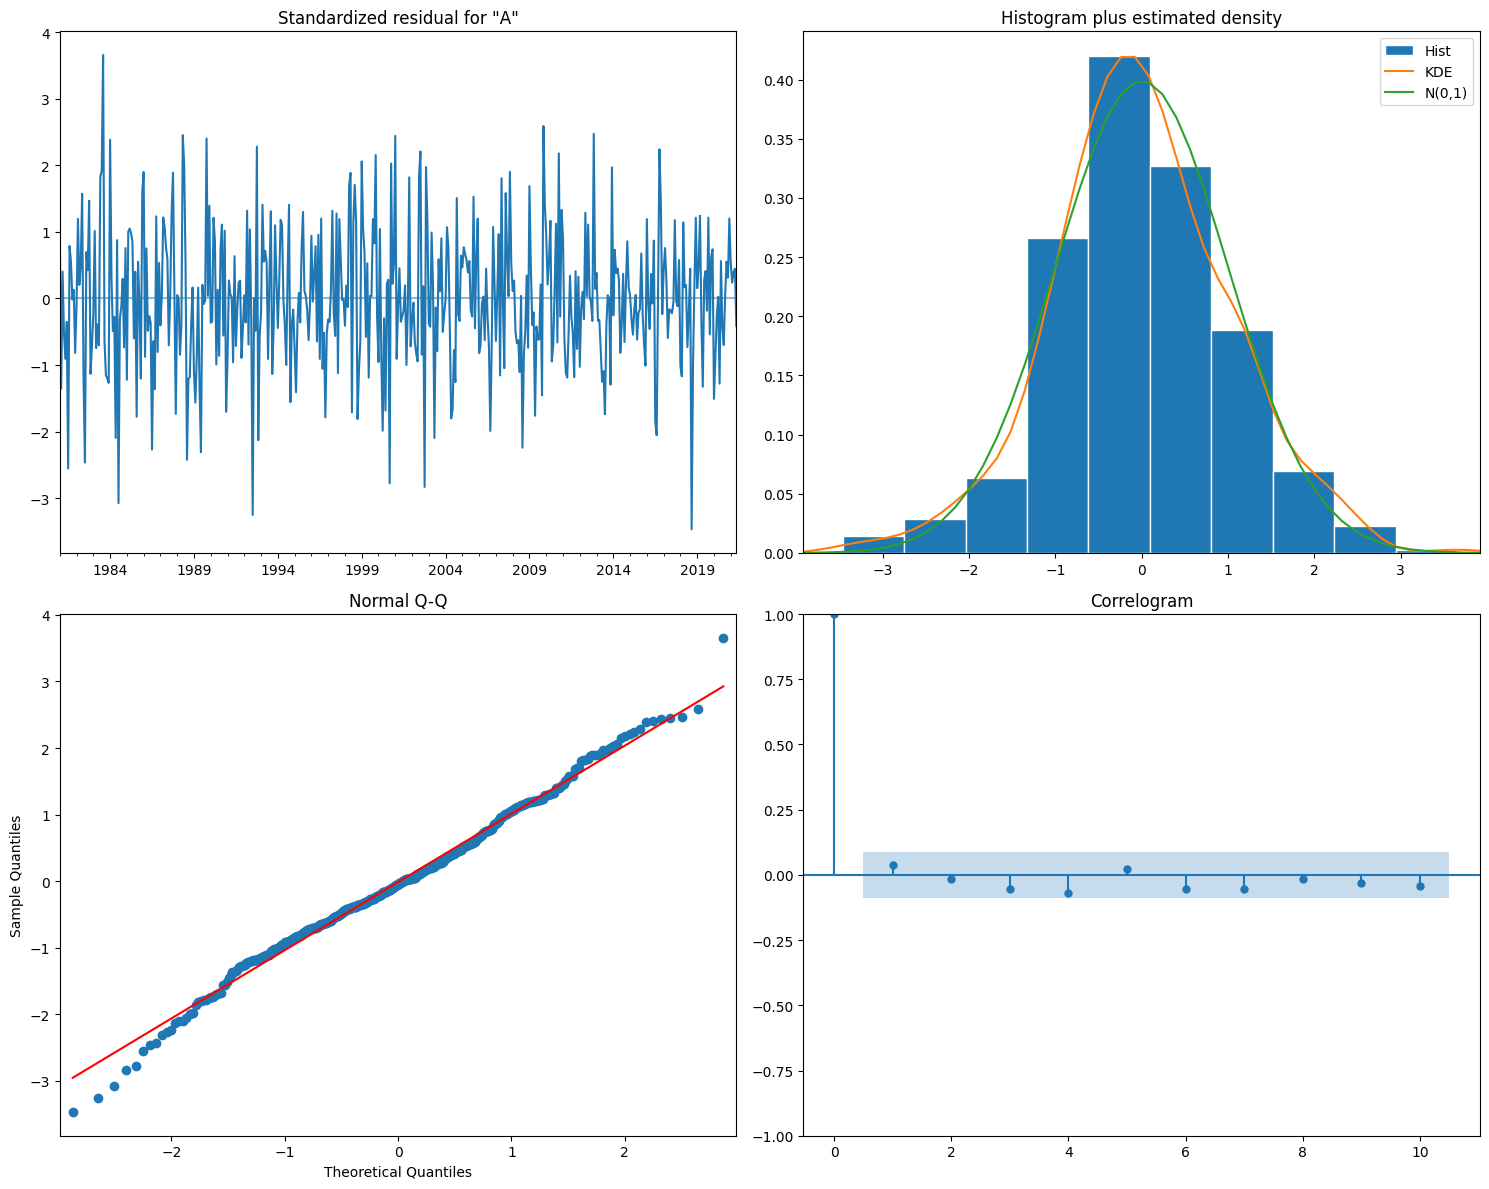

In [29]:
res2.plot_diagnostics(figsize=(15,12))
plt.tight_layout()

In [43]:
print(results1.aic)
print(results2.aic)
print(res2.aic) #downside: higher AIC than results1

-593.1905855449588
-600.1591283854259
-577.5344493374464


In [44]:
print(results1.aicc) #2nd highest, very close
print(results2.aicc) #lowest BIC
print(res2.aicc)

-593.0653245846248
-599.2655113641493
-576.6408323161698


In [45]:
print(results1.bic) #lowest BIC
print(results2.bic)
print(res2.bic)

-572.2698410902714
-541.5810439123011
-518.9563648643216


Model 1 had the lowest AIC, AICc, and BIC scores, plus it is simpler. So we stick with that.

### Forecasting with Model 1 -- SARIMA (2,0,1) x (0,1,1)_12:

In [46]:
# forecast test set
forecast = results1.predict(start = len(train),
                           end=len(df_bc),
                           typ='levels')

forecast.head()

2021-06-30    6.020436
2021-07-31    6.015494
2021-08-31    5.943384
2021-09-30    5.692237
2021-10-31    5.489535
Freq: M, Name: predicted_mean, dtype: float64

In [47]:
# get predictions and confidence intervals

get_forecast = results1.get_prediction(start = len(train),
                           end=len(df_bc),
                           typ='levels')

ci = get_forecast.conf_int()
ci.head()

,lower AQI,upper AQI
2021-06-30,5.768918,6.271954
2021-07-31,5.743127,6.287860
2021-08-31,5.665468,6.221301
2021-09-30,5.411667,5.972806
2021-10-31,5.207090,5.771979


Text(0.5, 1.0, 'Forecast of Box-Cox Transformed Data')

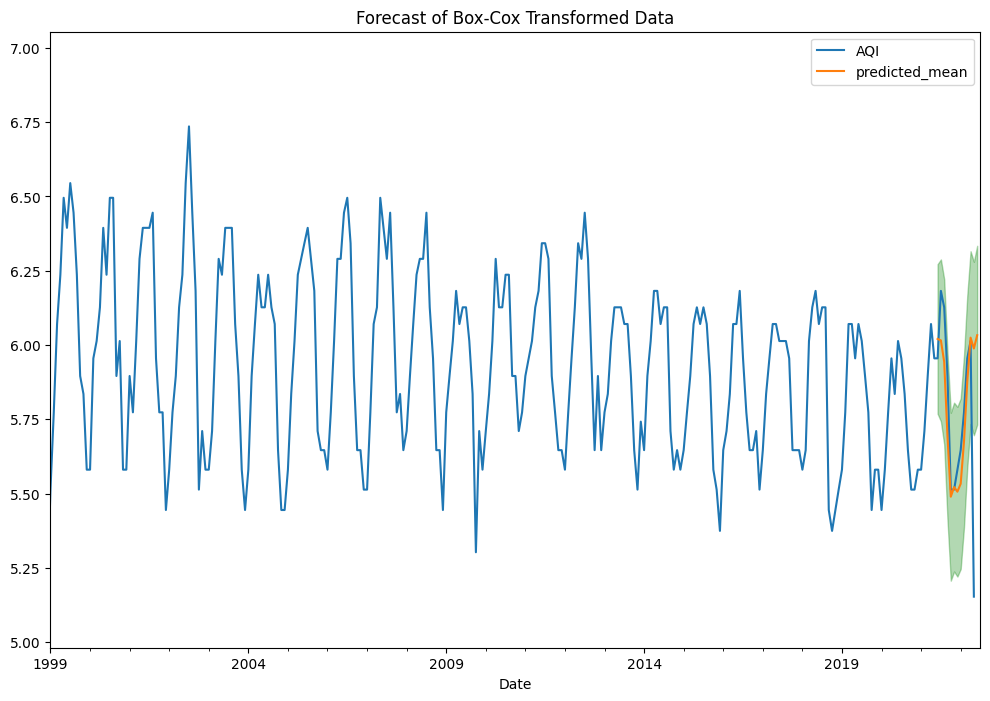

In [48]:
# plot
#fig, ax = plt.subplots()
ax=df_bc.plot(figsize=(12,8),legend=True)
forecast.plot(legend=True)

# plot Confidence Intervals!
ax.fill_between(
    ci.index, ci['lower AQI'], ci['upper AQI'],
    color='g', alpha=0.3
)

plt.xlim('1999-01-01', '2022-07-01')

plt.title('Forecast of Box-Cox Transformed Data')

Text(0.5, 1.0, 'Forecast of Box-Cox Transformed Data (Zoomed In)')

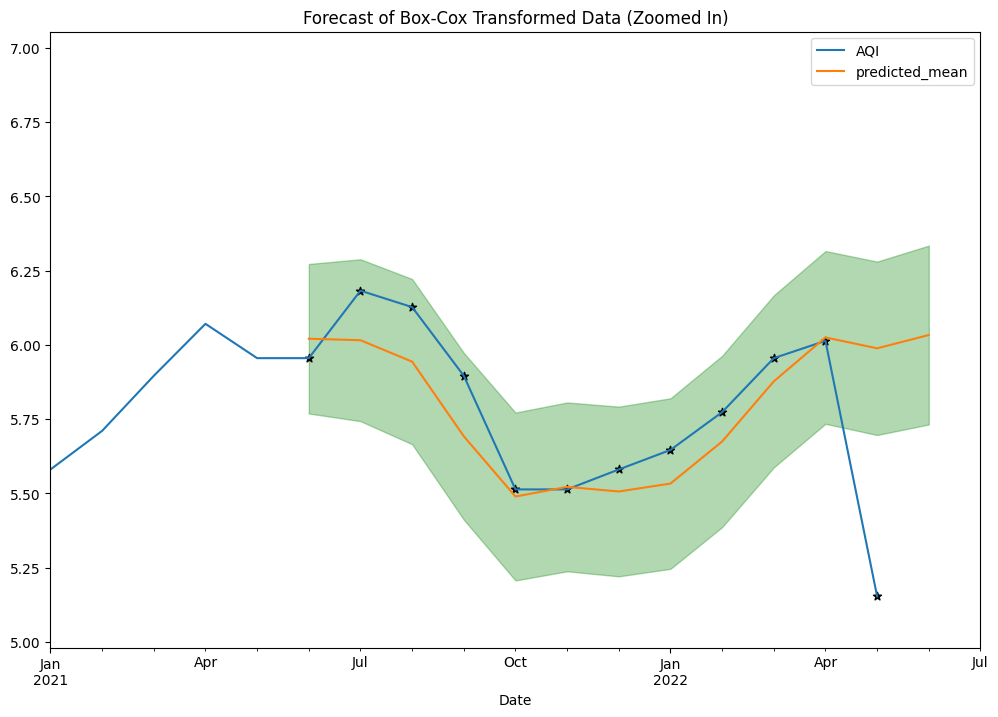

In [49]:
# zoom in plot

ax=df_bc.plot(figsize=(12,8),legend=True)
forecast.plot(legend=True)

ax.fill_between(
    ci.index, ci['lower AQI'], ci['upper AQI'],
    color='g', alpha=0.3
)

ax=plt.scatter(test.index, test.AQI, c='black', marker='*')


plt.xlim('2021-01-01', '2022-07-01')

plt.title('Forecast of Box-Cox Transformed Data (Zoomed In)')

### Forecasting on Untransformed Data

In [50]:
# inverse BoxCox

# predictions
pred_inv_bc = inv_boxcox(forecast, best_lambda)
#pred_inv_bc.head()

# confidence intervals
ci_inv_bc = inv_boxcox(get_forecast.conf_int(), best_lambda)
ci_inv_bc.head()

# train/ test
train_og = inv_boxcox(train, best_lambda)
test_og = inv_boxcox(test, best_lambda)

Text(0.5, 1.0, 'Forecast of Original Data')

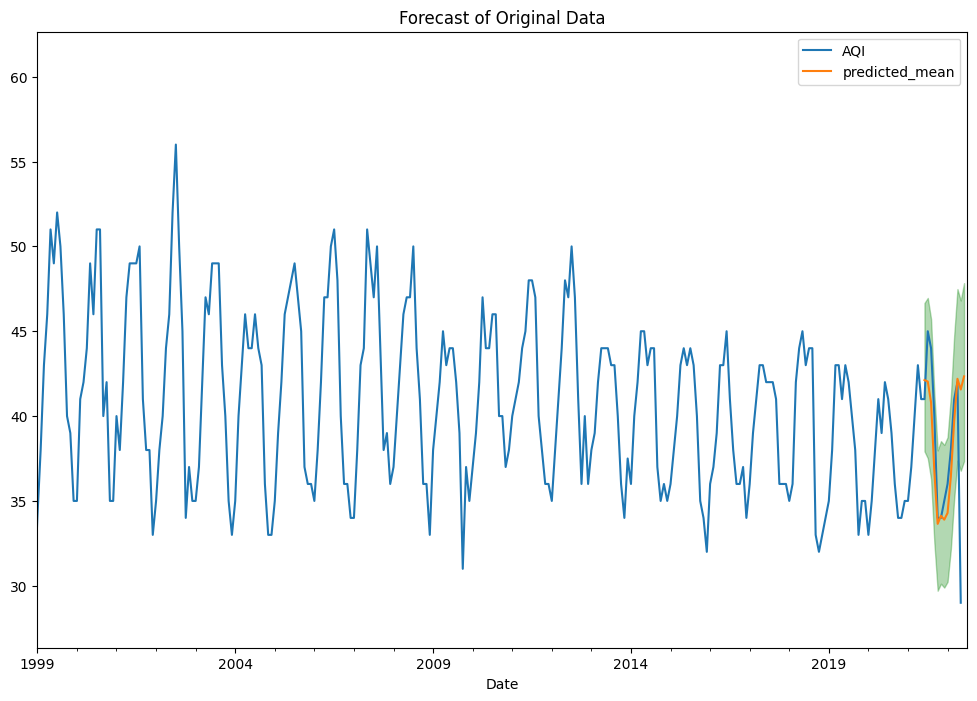

In [51]:
# plot
#fig, ax = plt.subplots()
ax=df.plot(figsize=(12,8),legend=True)
pred_inv_bc.plot(legend=True)

# plot Confidence Intervals!
ax.fill_between(
    pred_inv_bc.index, ci_inv_bc['lower AQI'], ci_inv_bc['upper AQI'],
    color='g', alpha=0.3
)

plt.xlim('1999-01-01', '2022-07-01')

plt.title('Forecast of Original Data')

Text(0.5, 1.0, 'Forecast of Original Data (Zoomed In)')

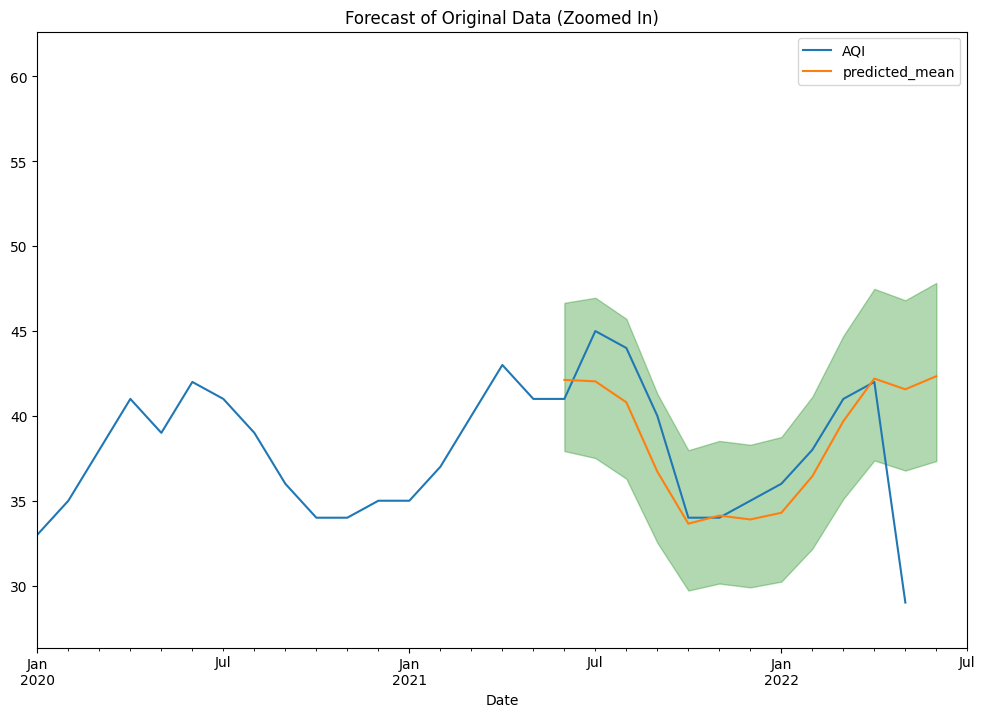

In [52]:
# plot
#fig, ax = plt.subplots()
ax=df.plot(figsize=(12,8),legend=True)
pred_inv_bc.plot(legend=True)

# plot Confidence Intervals!
ax.fill_between(
    pred_inv_bc.index, ci_inv_bc['lower AQI'], ci_inv_bc['upper AQI'],
    color='g', alpha=0.3
)

plt.xlim('2020-01-01', '2022-07-01')

plt.title('Forecast of Original Data (Zoomed In)')

### Score the model

In [53]:
#dataframe of predicted vs actual

preds = pd.DataFrame(pred_inv_bc[:-1])

df_results = test_og.join(preds)

#df_results['rmse'] = np.sqrt((df_results.AQI - df_results.predicted_mean)**2)

df_results

,AQI,predicted_mean
Date,,
2021-06-30,41.0,42.122046
2021-07-31,45.0,42.036347
2021-08-31,44.0,40.800989
2021-09-30,40.0,36.713327
2021-10-31,34.0,33.648460
2021-11-30,34.0,34.125473
2021-12-31,35.0,33.897029
2022-01-31,36.0,34.290973
2022-02-28,38.0,36.441293


In [54]:
rmse = np.sqrt(mean_squared_error(df_results.AQI, df_results.predicted_mean))
print('RMSE: ', rmse)

RMSE:  4.0562658214693155


In [40]:
# plot rmse over time
#plt.scatter(df_results.index, df_results.rmse)